In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import power_transform, StandardScaler

sns.set_style("whitegrid")
sns.set(font="sans-serif", rc={"axes.grid": True, "grid.color": "gray", "grid.alpha": 0.5})

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


In [2]:
data = pd.read_csv('/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv')

In [3]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
data.rename(columns=dict(map(lambda name:(name,'_'.join(name.split(' '))), data.columns.to_list())), inplace=True)

In [5]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
X = data.drop(columns=['quality'], axis=1)
y = data.loc[:,'quality']

In [7]:
def split_outliers(df: pd.DataFrame, col:str, viz=True):
    q1,q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    iqr = q3-q1
    upper_tail = q3 + 1.5*iqr
    lower_tail = q1 - 1.5*iqr
    upper = df[col]>upper_tail
    lower = df[col]<lower_tail
    outliers_mask = upper|lower
    
    outliers = df.loc[outliers_mask, col]
    non_outliers = df.loc[~outliers_mask, col]
    
    if viz:
        ax=sns.scatterplot(x=outliers, y=y[outliers.index], color='red', alpha=0.65, label='Outliers')
        sns.scatterplot(x=non_outliers, y=y[non_outliers.index], color='green', alpha=0.35, ax=ax, label='Non-outliers')
        plt.legend()
        plt.show()

        fig,ax=plt.subplots(figsize=(4,5))
        oc = len(outliers.index)
        noc = len(non_outliers.index)
        sns.barplot(pd.DataFrame(
            {'outlier':[oc*100/(oc+noc)],'non_outlier':[noc*100/(oc+noc)]}, index=np.arange(1)
        ), ax=ax, palette=['#7AB','#EDA'])
        ax.bar_label(ax.containers[0],fmt='%.2f', label_type='center')
        ax.set(ylabel='percentage')
        plt.show()
    
    return (outliers, non_outliers)

In [8]:
class MeanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, trim=0.1):
        self.trim = trim

    def trimmed_mean(self, seq:np.array, trim=0.1):
        ss = sorted(seq)
        n = len(ss)
        trim_cnt = int(trim*n)
        return np.mean(ss[trim_cnt:-trim_cnt])
    
    def fit(self, X:pd.DataFrame, y=None):
        self.impute_col = dict()
        for col in X.columns:
            outliers,non_outliers=split_outliers(X,col,viz=False)
            self.impute_col[col]=(outliers.index, self.trimmed_mean(non_outliers))
        return self
    def transform(self, X:pd.DataFrame):
        X = X.copy()
        for col in X.columns:
            if col in self.impute_col:
                idx,m=self.impute_col[col]
                X.loc[idx,col]=m
        return X


In [9]:
class PowerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, method='box-cox'):
        self.method = method
    def fit(self, X, y=None):
        return self
    
    def transform(self, X:pd.DataFrame):
        X = X.copy()
        for col in X.columns:
            method = self.method
            if sum(X[col]<=0)>0:
                print(f'PowerTransformer: The column {col} contains non-positive values. Falling back to Yeo-Johnson Transform')
                method='yeo-johnson'
            X[col] = power_transform(X[[col]], method=method)
        return X

In [10]:
def explore(df: pd.DataFrame, col:str):
    fig,axes=plt.subplots(sharex=True, nrows=2,ncols=1)
#     Display distribution
    sns.histplot(data=X, x=col, kde=True, ax=axes[0], color='salmon', alpha=0.65)
    sns.boxplot(data=X, x=col, ax=axes[1], color='0.8', linewidth=.75)
    
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


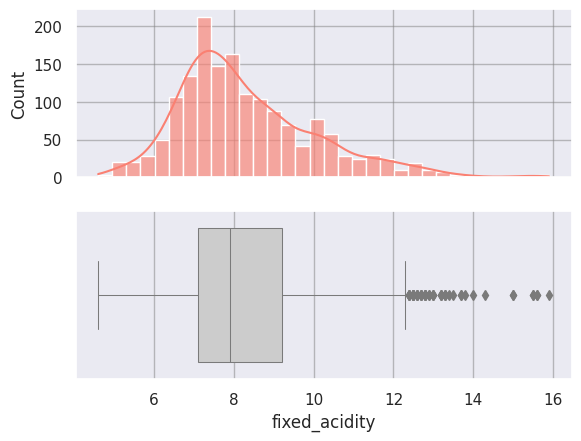

In [11]:
explore(X, 'fixed_acidity')

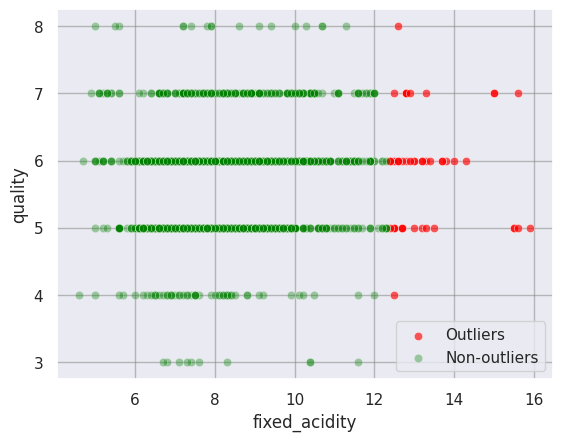

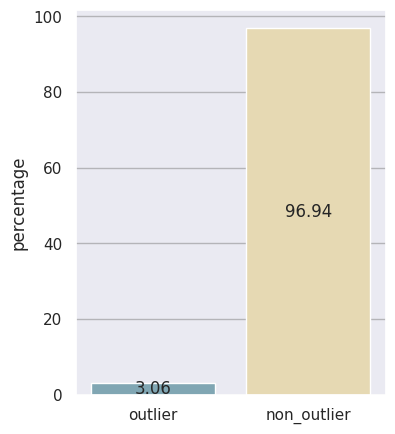

In [12]:
outliers,non_outliers = split_outliers(X, 'fixed_acidity')

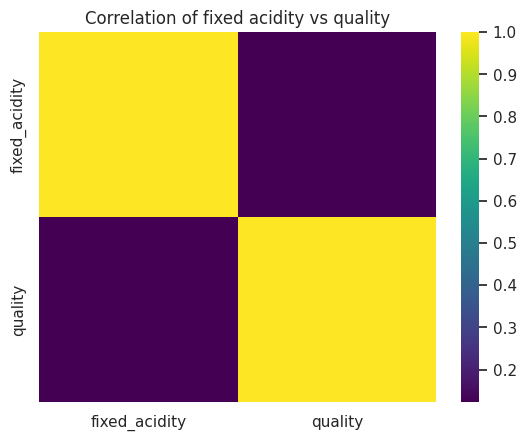

In [13]:
sns.heatmap(data[['fixed_acidity','quality']].corr(),cmap='viridis')
plt.title('Correlation of fixed acidity vs quality')
plt.show()

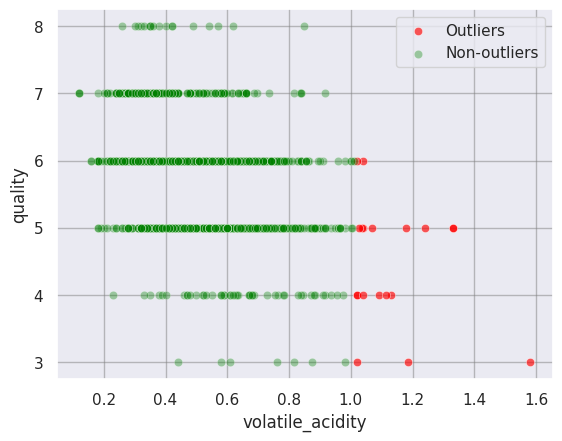

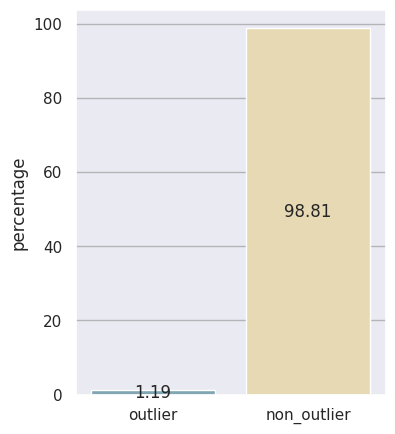

In [14]:
_,_=split_outliers(X,'volatile_acidity')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


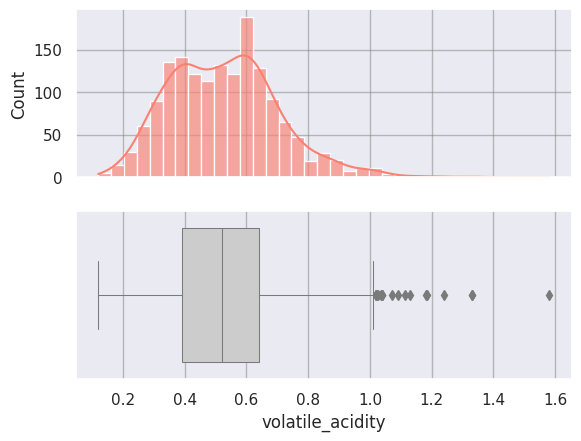

In [15]:
explore(X,'volatile_acidity')

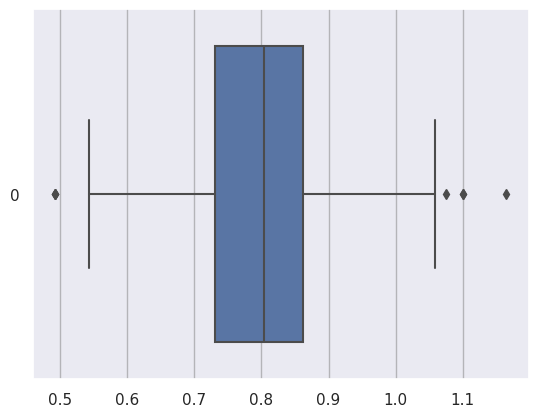

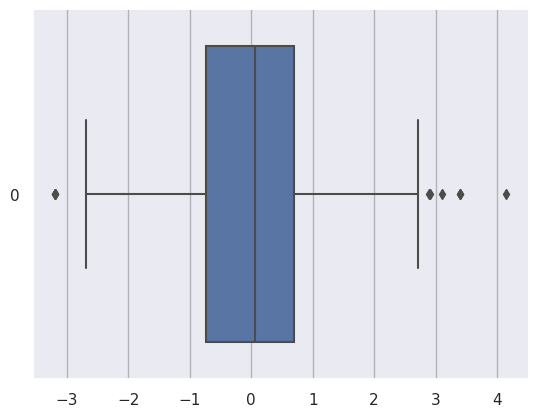

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


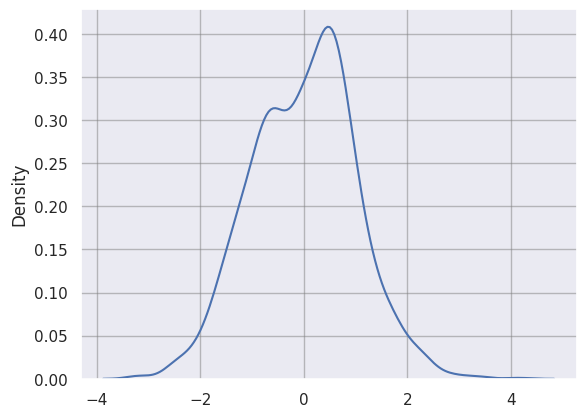

In [16]:
_X = X.copy()

sns.boxplot(_X['volatile_acidity']**(1/3), orient='h')
plt.show()

sns.boxplot(np.reshape(power_transform(_X[['volatile_acidity']], method='box-cox'), (-1,)), orient='h')
plt.show()

sns.kdeplot(np.reshape(power_transform(_X[['volatile_acidity']], method='box-cox'), (-1,)))
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='volatile_acidity', ylabel='Density'>

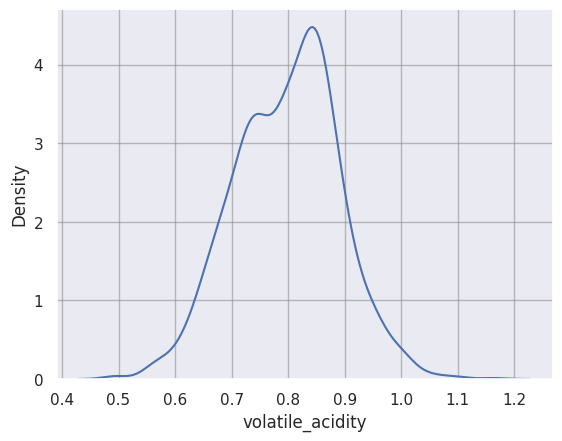

In [17]:
sns.kdeplot(_X['volatile_acidity']**(1/3))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

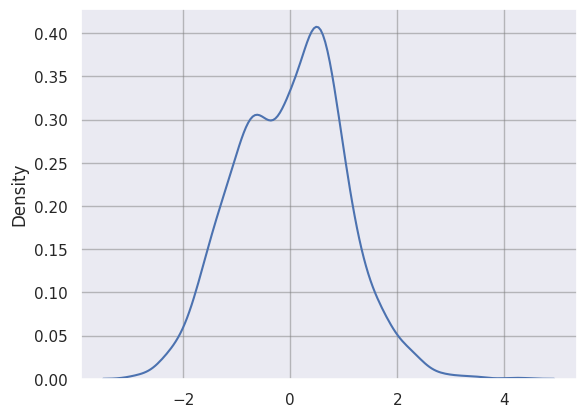

In [18]:
scaler = StandardScaler()
d = scaler.fit_transform(_X[['volatile_acidity']])
d = power_transform(d, method='yeo-johnson')
sns.kdeplot(np.reshape(d, (-1,)))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


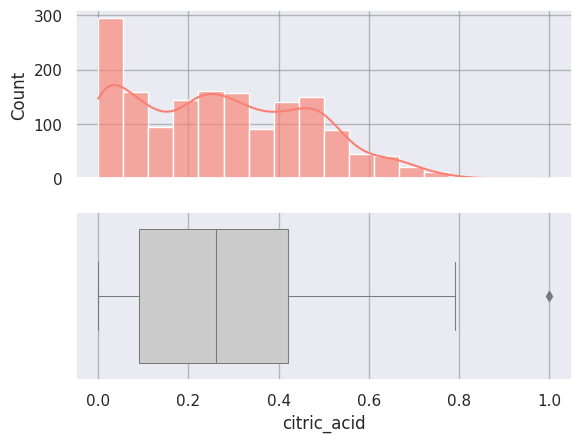

In [19]:
explore(X, 'citric_acid')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


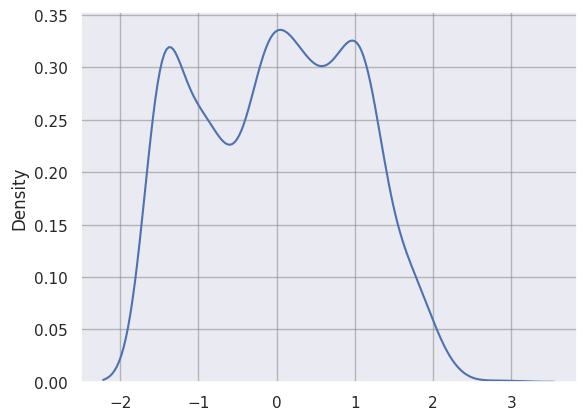

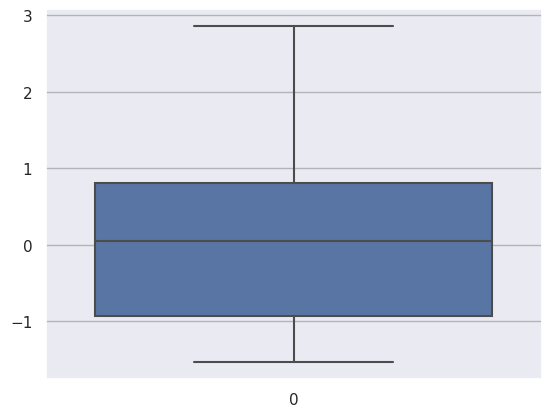

In [20]:
sns.kdeplot(np.reshape(power_transform(_X[['citric_acid']], method='yeo-johnson'), (-1,)))
plt.show()

sns.boxplot(np.reshape(power_transform(_X[['citric_acid']], method='yeo-johnson'), (-1,)))
plt.show()

In [21]:
sum(_X['citric_acid']<=0)

132

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


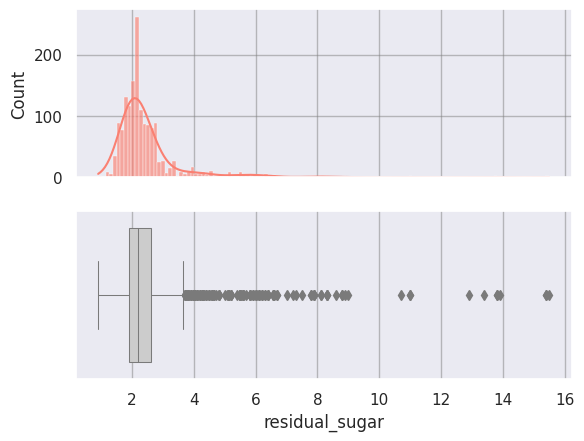

In [22]:
explore(_X, 'residual_sugar')

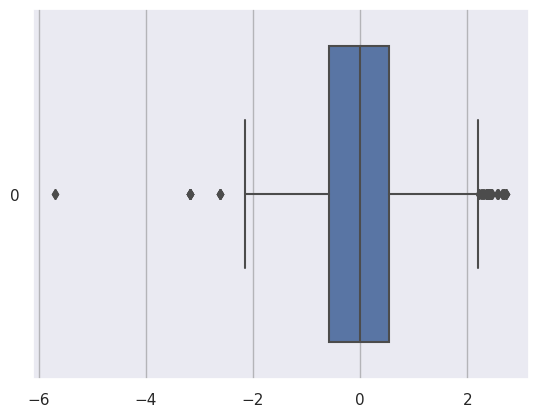

In [23]:
sns.boxplot(np.reshape(power_transform(_X[['residual_sugar']], method='box-cox'), (-1,)), orient='h')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


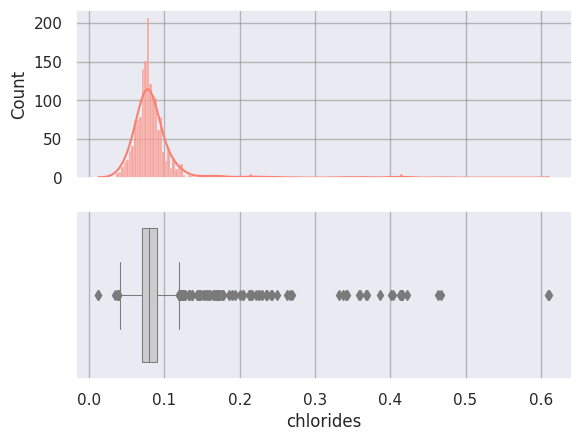

In [24]:
explore(_X, 'chlorides')

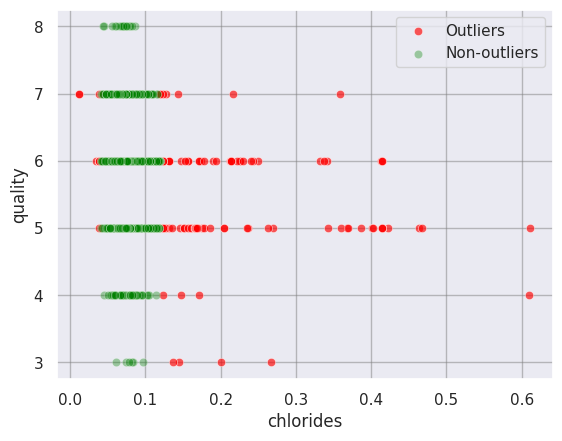

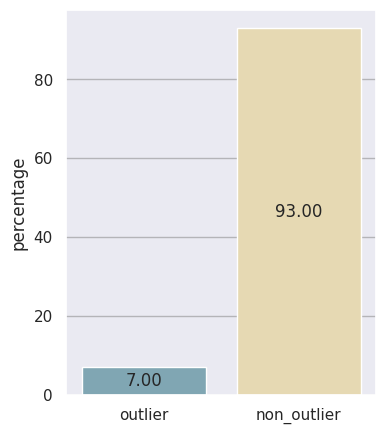

In [25]:
_,_=split_outliers(_X,'chlorides')

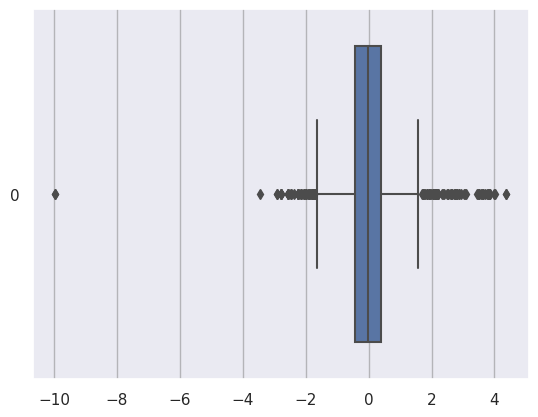

In [26]:
sns.boxplot(np.reshape(power_transform(_X[['chlorides']], method='box-cox'), (-1,)), orient='h')
plt.show()

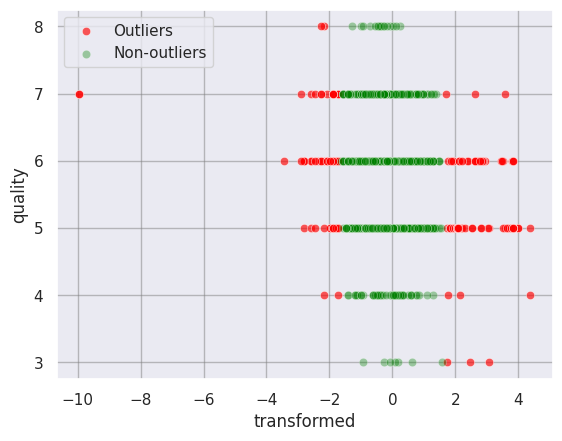

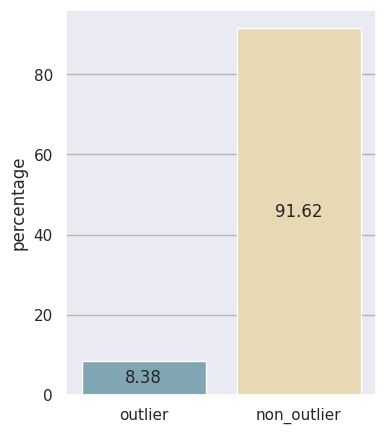

In [27]:
outliers,_=split_outliers(pd.DataFrame({'transformed': np.reshape(power_transform(_X[['chlorides']], method='box-cox'), (-1,))}, index=_X.index), 'transformed')

In [28]:
def trimmed_mean(seq:np.array, trim=0.1):
    ss = sorted(seq)
    n = len(ss)
    trim_cnt = int(trim*n)
    print(trim_cnt)
    return np.mean(ss[trim_cnt:-trim_cnt])

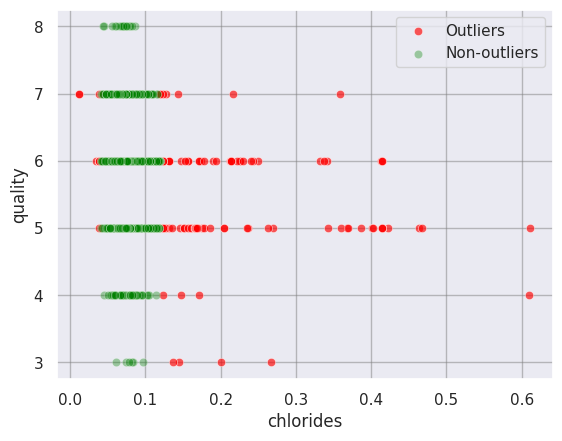

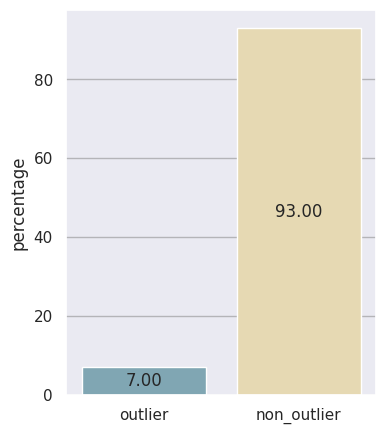

446


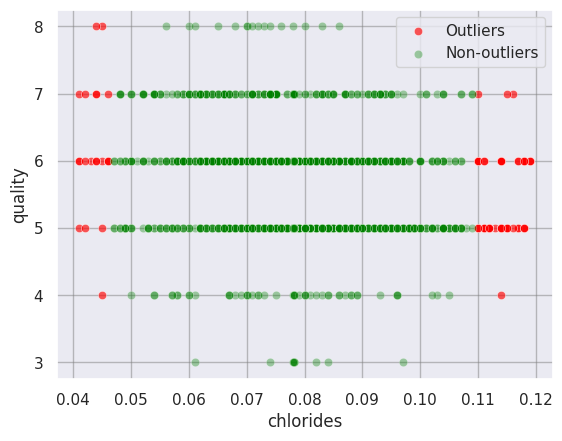

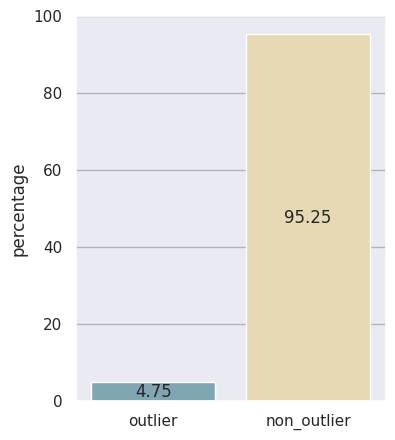

In [29]:
_X = X.copy()
outliers,non_outliers=split_outliers(_X, 'chlorides')
_X.loc[outliers.index,['chlorides']]=trimmed_mean(non_outliers,0.3)
_,_=split_outliers(_X, 'chlorides')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


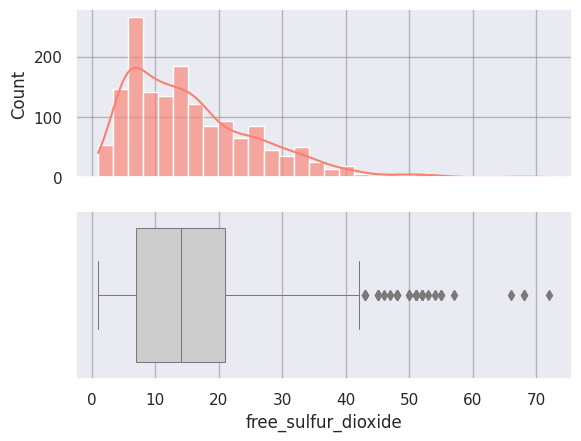

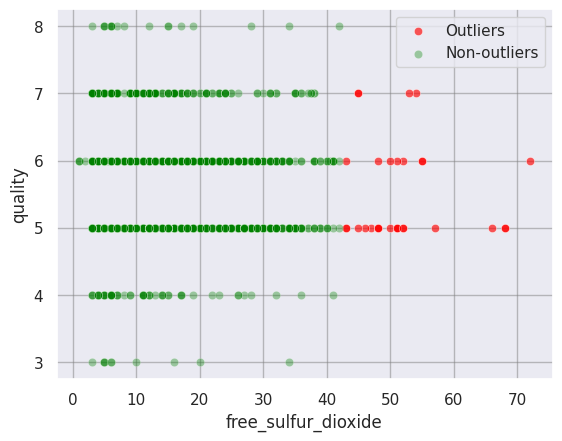

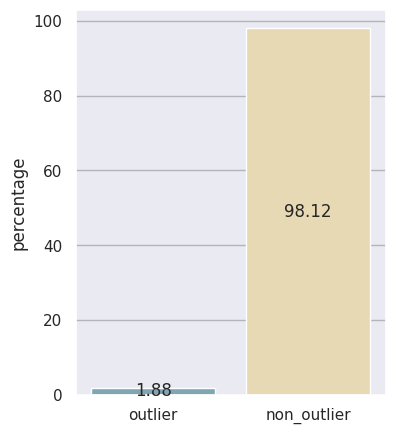

In [30]:
_X = X.copy()
explore(_X, 'free_sulfur_dioxide')
_,_= split_outliers(X,'free_sulfur_dioxide')

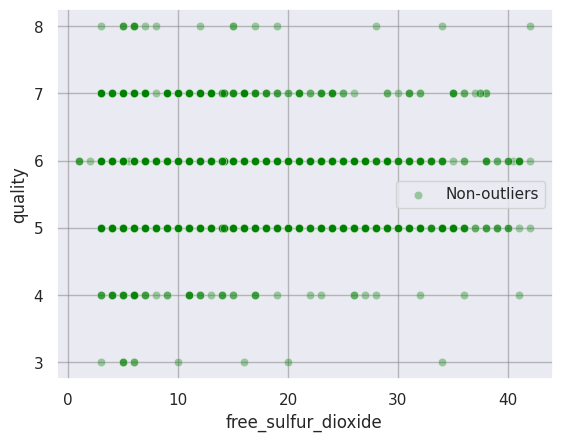

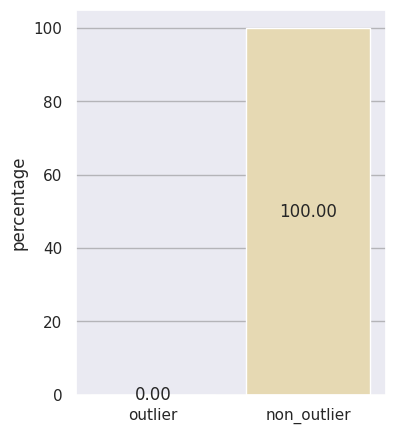

In [31]:
_X[['free_sulfur_dioxide']] = MeanTransformer().fit_transform(X[['free_sulfur_dioxide']])
_,_ = split_outliers(_X, 'free_sulfur_dioxide')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


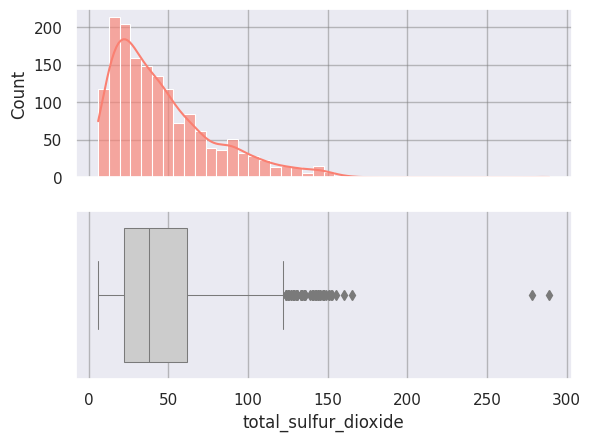

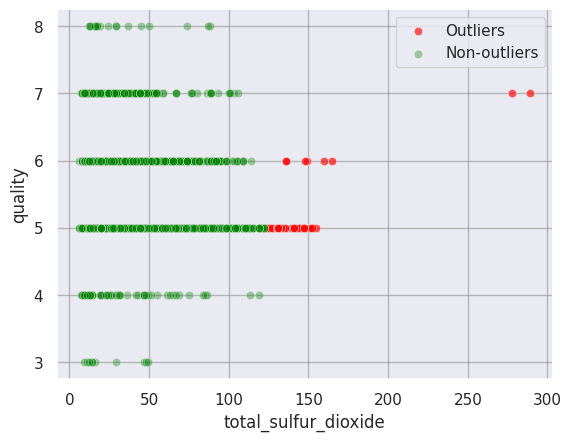

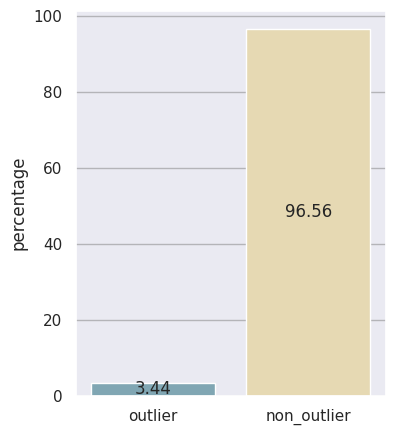

In [32]:
_X = X.copy()
explore(_X, 'total_sulfur_dioxide')
_,_ = split_outliers(_X, 'total_sulfur_dioxide')

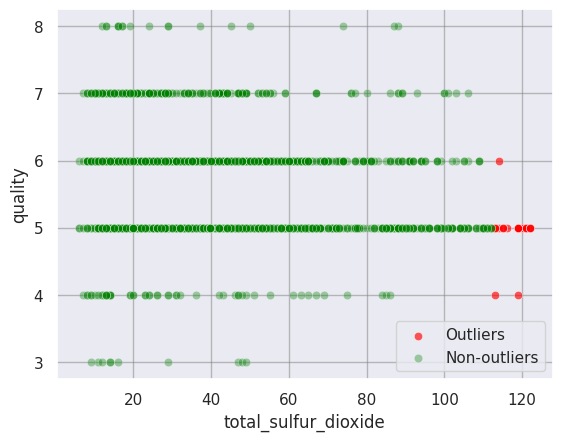

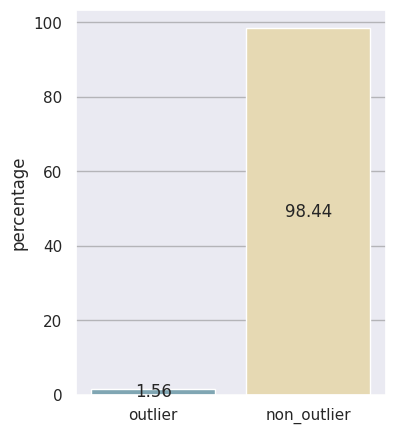

In [33]:
_X[['total_sulfur_dioxide']] = MeanTransformer().fit_transform(X[['total_sulfur_dioxide']])
_,_ = split_outliers(_X, 'total_sulfur_dioxide')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


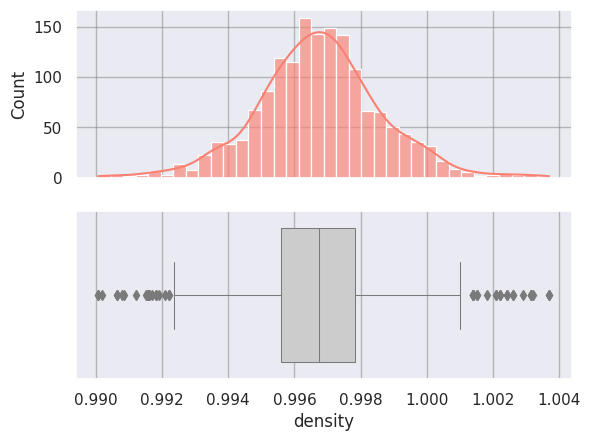

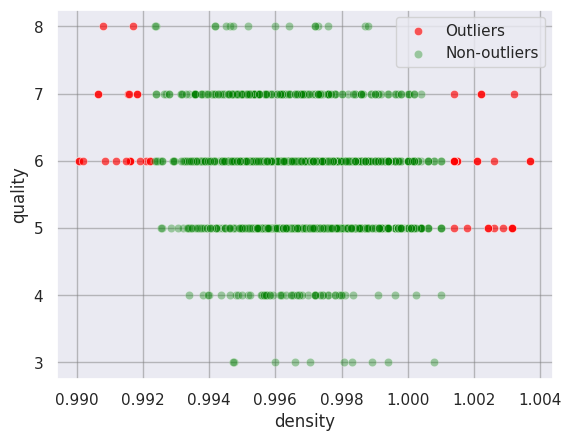

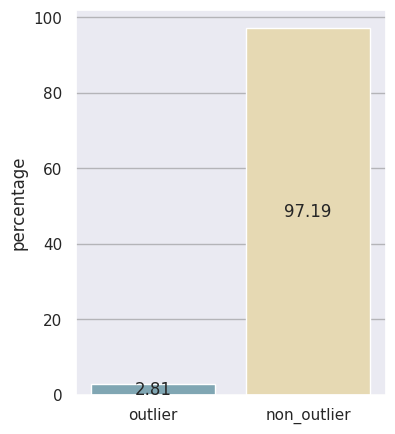

In [34]:
_X = X.copy()
explore(_X, 'density')
_,_ = split_outliers(_X, 'density')

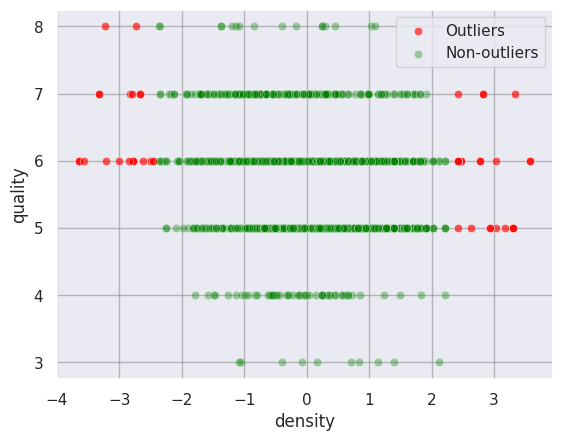

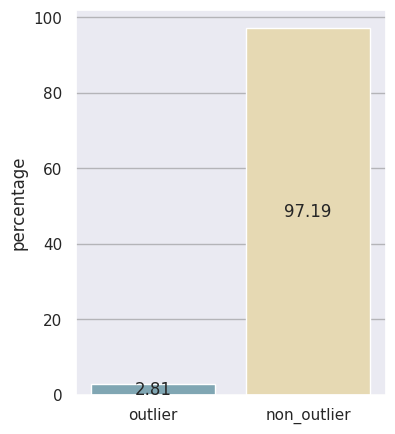

In [35]:
_X = PowerTransformer().fit_transform(X[['density']])
_,_ = split_outliers(_X,'density')

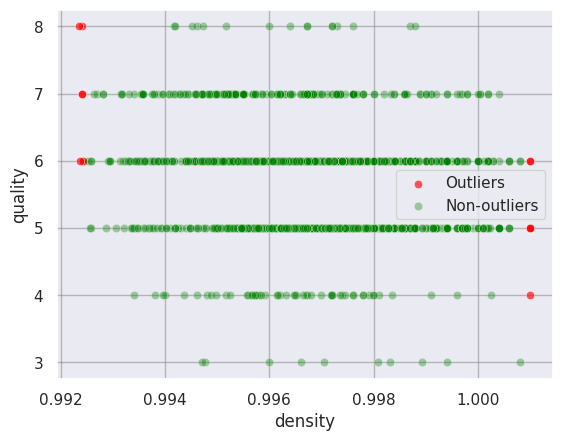

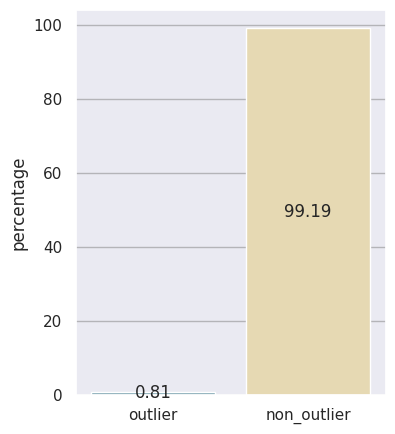

In [36]:
_X = MeanTransformer().fit_transform(X[['density']])
_,_ = split_outliers(_X,'density')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


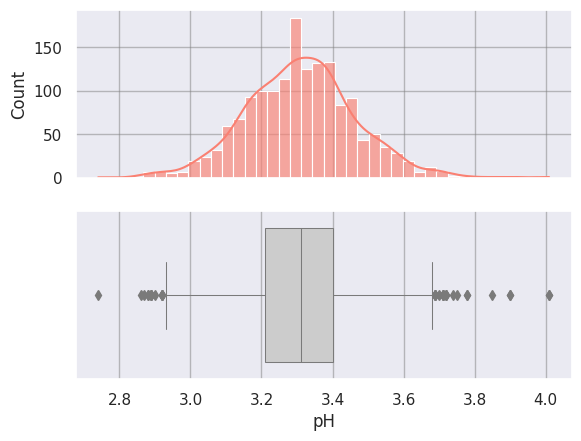

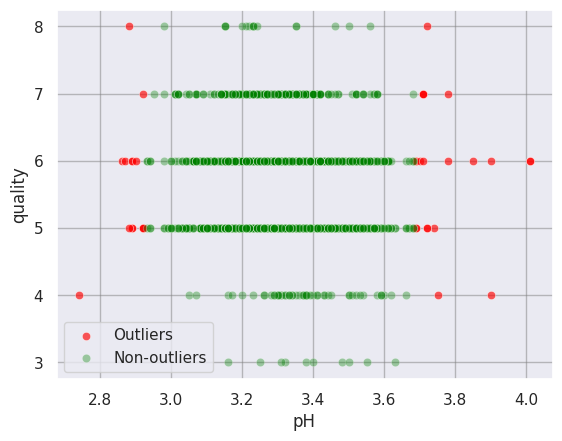

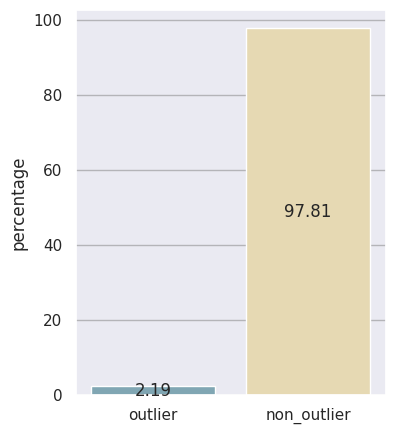

In [37]:
_X = X.copy()
explore(_X, 'pH')
_,_ = split_outliers(_X, 'pH')

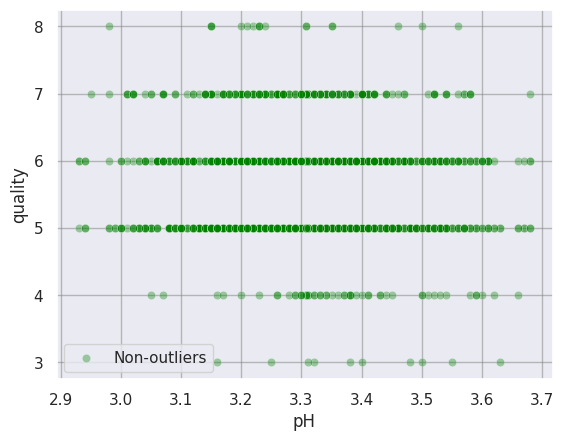

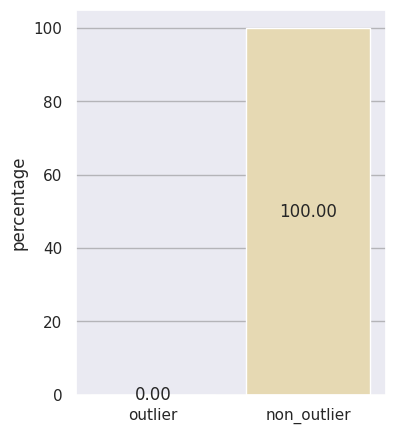

In [39]:
_X = MeanTransformer().fit_transform(X[['pH']])
_,_ = split_outliers(_X,'pH')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


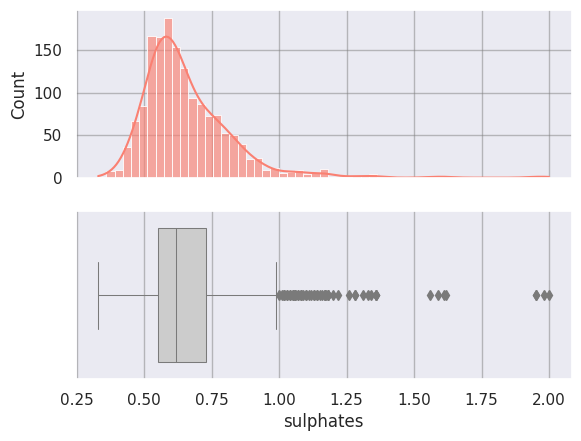

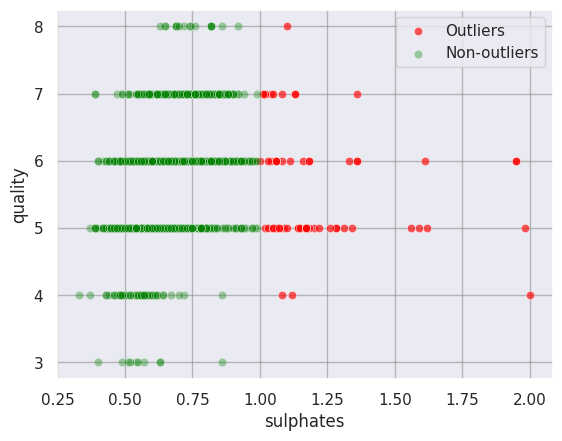

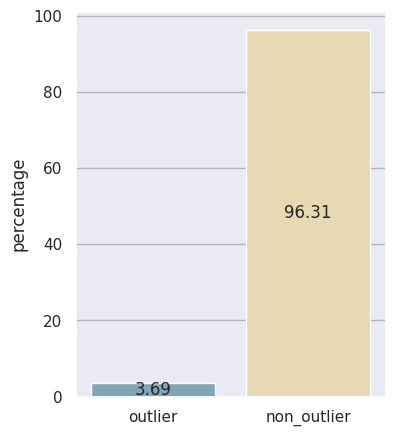

In [41]:
_X = X.copy()
explore(_X, 'sulphates')
_,_ = split_outliers(_X, 'sulphates')

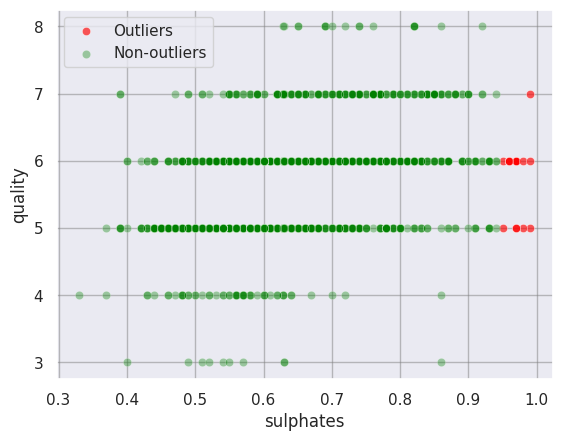

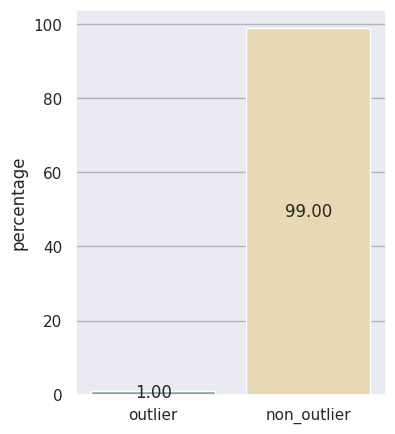

In [44]:
_X = MeanTransformer().fit_transform(X[['sulphates']])
_,_ = split_outliers(_X,'sulphates')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


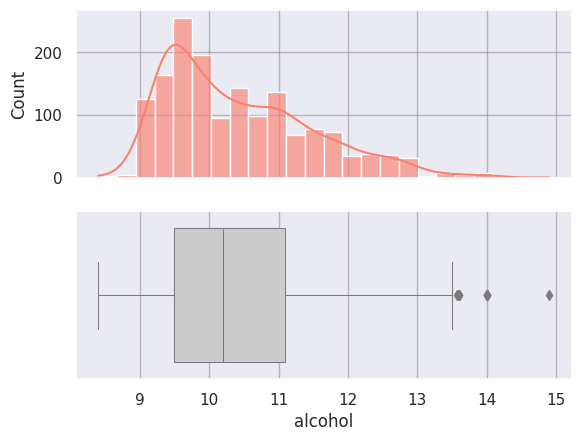

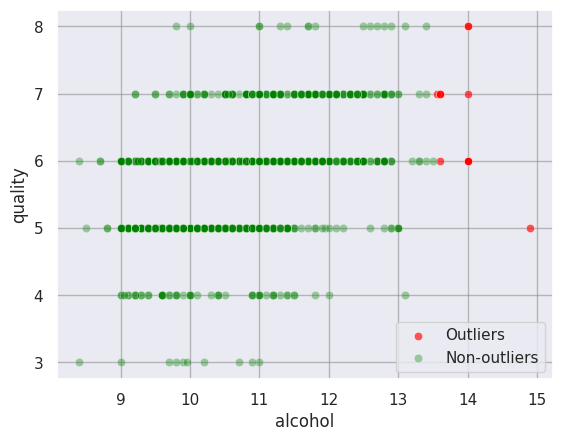

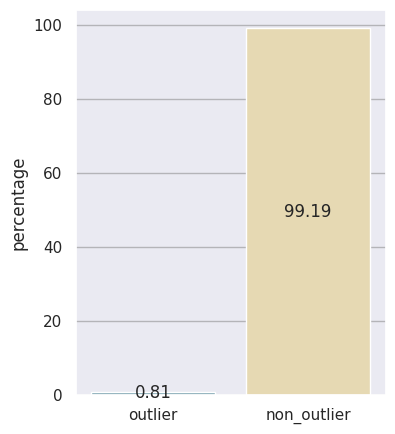

In [46]:
_X = X.copy()
explore(_X, 'alcohol')
_,_ = split_outliers(_X, 'alcohol')

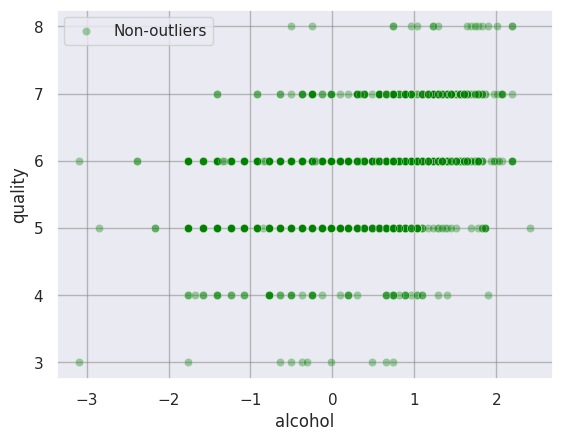

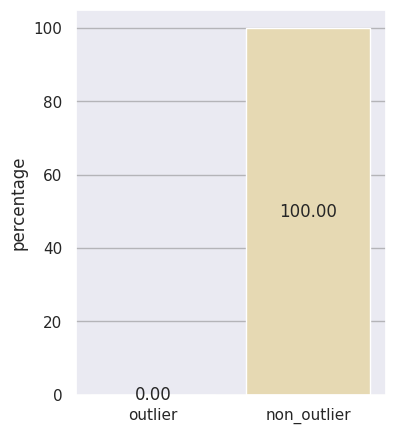

In [48]:
_X['alcohol'] = PowerTransformer().fit_transform(X[['alcohol']])
_,_ = split_outliers(_X, 'alcohol')